<a href="https://colab.research.google.com/github/tj-Tanmay812/Mini-Project/blob/main/Image_Classification_of_Sign_Language_using_Logistic_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Classification of Sign Language using Logistic Regression**

First we start by installing these libraries
*   Numpy and Pandas — for data handling and processing

*   PyTorch and Torchvision — for machine learning functions

*   Matplotlib — for data visualization

*   Jovian — for saving the code in the jovian.ml platform

In [ ]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Now importing the above libraries

In [ ]:
# Imports
import torch
import jovian
import torchvision
import string
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

**Pre-processing the data**

In [ ]:
# Hyperparameters
batch_size = 256
learning_rate = 1e-5

# Other constants
input_size = 28*28
num_classes = 26

Now loading the training and testing dataset.

In [ ]:
import os
# os.chdir('/kaggle/input/sign-language-mnist/')
dataset = pd.read_csv('sign_mnist_train.csv')
testdataset = pd.read_csv('sign_mnist_test.csv')
num_rows = dataset.shape[0]
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))

**Exploring the data.**

Constructing a function to split the training and testing dataset to separate the labels from the pixel values

In [ ]:
def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_array(dataset)
testinputs_array, testtargets_array = dataframe_to_array(testdataset)

Rshaping the array to (28x28) since the initial shape is just a row array.

Letter:  D


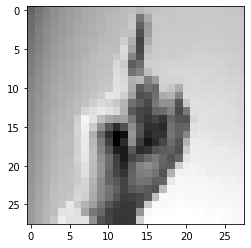

In [ ]:
pic1 = np.reshape(inputs_array[0], (28, 28))
plt.imshow(pic1, cmap = "gray")
print("Letter: ", letters[targets_array[0].item()])

As expected, the letter in the hand image is D. However, it is evident that the image is not clear due to its small resolution.

Converting the training and testing input arrays to continuous float values since it allows our model for a more precise learning as compared to discrete values. 

On the other hand converting the training and testing labels to long integers since the output of the model are indices to be used in accessing probability values.

In [ ]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).long()
testinputs = torch.from_numpy(testinputs_array).float()
testtargets = torch.from_numpy(testtargets_array).long()

**Dataset and Data Loaders**

In this part the input arrays and label arrays are wrapped in a single object for both the training and testing datasets.The training dataset will also be split to a training and validation subset. In this case, 15% of the original training dataset will be placed in the validation subset.

The data loaded for the training dataset are also shuffled since there might be a chance that the elements in a batch are homogenous (i.e. all are from one category) which might lead to an inaccurate model.

In [ ]:
# Training validation & test dataset
dataset = TensorDataset(inputs, targets)
testdataset = TensorDataset(testinputs, testtargets)

# Let's use 15% of our training dataset to validate our model
val_percent = 0.15
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(testdataset, batch_size*2)

Looking at the first entry of the training dataset.

Letter:  I


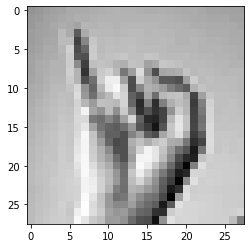

In [ ]:
img, label = train_ds[0]
plt.imshow(img.reshape((28,28)), cmap = 'gray')
print("Letter: ", letters[label.item()])

Since this image is different from the image we saw earlier, there is an assurance that the datasets are randomly split and shuffled.

**Constructing the Model**

The function returns a tensor with 26 elements with values ranging from negative infinity to positive infinity. Well, technically not infinite since the values are limited by the number of bits allocated in the memory. As such, the values must be normalized between 0 and 1.0 inclusive.
Here, I used PyTorch’s cross_entropy function that combines the negative log likelihood and softmax function to normalize the resulting values from the linear function.

The code for constructing the image classification model is this.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Upon instantiating the class, random weight values and bias values are created. Hence the need for the training_step and validation_step methods. On the other hand, the validation_epoch_end and epoch_end methods are there to present the current performance to model.

**Training the Model**

Here we will define the accuracy of the model by dividing the amount of times the model correctly predicts the image by the total number of input images.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Using Stochastic Gradient Descent to determine how well the model is improving.

Linear regression works by fitting a curve that represents the relationship between the data points.We aim to improve the model by gradually reaching the local minima of the loss function to minimize the losses.The rate of adjustment from the initial parameters to the new parameters is dictated by the learning rate. Earlier, the learning rate was defined to be 1e-5.

The rate of adjustment from the initial parameters to the new parameters is dictated by the learning rate. Earlier, the learning rate was defined to be 1e-5.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Let’s evaluate our model.**


In [ ]:
evaluate(model, val_loader)

{'val_acc': 0.03651751950383186, 'val_loss': 151.767333984375}

Since the model parameters are random upon instantiation, it is expected that the accuracy is very low and the validation loss is high. 

The next step is training the model for 50 epoch or 50 iterations with a learning rate of 1e-4.

In [ ]:
history = fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 433.2159, val_acc: 0.1763
Epoch [1], val_loss: 367.5898, val_acc: 0.1021
Epoch [2], val_loss: 253.6525, val_acc: 0.1605
Epoch [3], val_loss: 193.5671, val_acc: 0.2184
Epoch [4], val_loss: 184.9161, val_acc: 0.2495
Epoch [5], val_loss: 86.6385, val_acc: 0.3615
Epoch [6], val_loss: 110.7273, val_acc: 0.2702
Epoch [7], val_loss: 79.0897, val_acc: 0.4066
Epoch [8], val_loss: 104.5577, val_acc: 0.3600
Epoch [9], val_loss: 79.0220, val_acc: 0.3539
Epoch [10], val_loss: 124.3715, val_acc: 0.1544
Epoch [11], val_loss: 124.9072, val_acc: 0.3344
Epoch [12], val_loss: 42.9289, val_acc: 0.4388
Epoch [13], val_loss: 44.7906, val_acc: 0.5585
Epoch [14], val_loss: 29.1867, val_acc: 0.5704
Epoch [15], val_loss: 33.0428, val_acc: 0.6072
Epoch [16], val_loss: 41.6434, val_acc: 0.5677
Epoch [17], val_loss: 14.4908, val_acc: 0.7072
Epoch [18], val_loss: 19.5488, val_acc: 0.6668
Epoch [19], val_loss: 42.0439, val_acc: 0.5765
Epoch [20], val_loss: 64.0039, val_acc: 0.3316
Epoch [21], va

**Visualizing model performance in graph.**

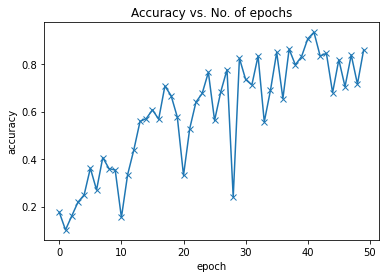

In [ ]:
# Visualizing how our model performed after each epoch
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

As seen from the graph, as the amount of epochs increases, the accuracy of the model increases. However, it is worthy to note that the model was somewhat unstable as there are dips in the accuracy of the model. This could be attributed to a large learning rate.

Trying to evaluate the model using the testing dataset.

In [ ]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.62890625, 'val_loss': 18.430368423461914}

The accuracy of the model is aproximately 60%.

**Using the Model to Predict Images**

Now creating a helper function to pass an image to the model and return the model prediction. The code for this function is :

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Running the function.

Label: H , Predicted: H


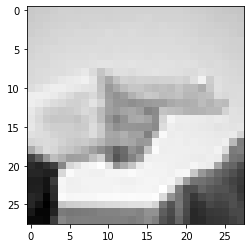

In [ ]:
img, label = testdataset[919]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model)])

In this example, the model correctly predicts the letter portrayed by the hand image. Let’s try another one.

Label: H , Predicted: H


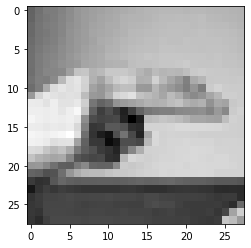

In [ ]:
img, label = testdataset[19]
plt.imshow(img.reshape(28,28), cmap='gray')
print('Label:', letters[label.item()], ', Predicted:', letters[predict_image(img, model)])

**Saving the Model**

In [ ]:
# Here the model parameters are saved so that we dont have to train the model next time
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
# Let's look at the model parameters
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0005,  0.0229,  0.0347,  ...,  0.0031,  0.0220, -0.0252],
                      [ 0.0029,  0.0163,  0.0350,  ...,  0.0331, -0.0395, -0.0018],
                      [ 0.0348, -0.0136,  0.0265,  ..., -0.0067,  0.0593,  0.0193],
                      ...,
                      [ 0.0397,  0.0102, -0.0142,  ...,  0.0106,  0.0433,  0.0165],
                      [ 0.0238, -0.0233,  0.0097,  ..., -0.0093, -0.0464, -0.0177],
                      [ 0.0083,  0.0282, -0.0126,  ..., -0.0285, -0.0250, -0.0312]])),
             ('linear.bias',
              tensor([-0.0194,  0.0095, -0.0125,  0.0187,  0.0246,  0.0275,  0.0046,  0.0349,
                       0.0183, -0.0338,  0.0070, -0.0195,  0.0256,  0.0324,  0.0149,  0.0063,
                       0.0049, -0.0036, -0.0070,  0.0305, -0.0266, -0.0180,  0.0124, -0.0280,
                      -0.0029, -0.0084]))])

**Conclusion**

Logistic regression was used to construct the model with accuracy aproximately 50%. From the trend of the performance of the model, increasing the number of training epochs also increases the training accuracy of the model. However, the training accuracy of the model will somewhat plateau at about 80–90%.

This may be the limitation of constructing the model using just logistic regression. Other more sophisticated models could result to a higher accuracy.